In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mprod import  m_prod
from mprod import  generate_haar, generate_dct
from numpy import linalg as LA
from scipy.stats import ortho_group
from scipy.fft import dct, idct, rfft, irfft

In [2]:
def tensor_frob_norm(A):
    return np.sqrt((A**2).sum())

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# assighn random tensor A (dominant diagonal) and b

In [3]:
m, p, n = 1000, 100, 10
funm_dct, invm_dct = generate_haar(n, random_state=100)

np.random.seed(0)
A_orig = np.random.randn(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.randn(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

A_tensor_mult_M = funm_dct(A_tensor)

print('\ncondition number of each frontal slice')
for i in range(n):
    print(LA.cond(A_tensor[:,:,i]))
    
print('\ncondition number of each frontal slice of A^hat')        
for i in range(n):
    print(LA.cond(A_tensor_mult_M[:,:,i]))


condition number of each frontal slice
311.4610065095237
16.73035410655449
4.539813961722965
303.76269026174396
3.4281865266138376
206.6488718310949
1.9900544746715567
201.21912617075634
1.8533960789962758
121.66874388248407

condition number of each frontal slice of A^hat
3.4794560836205286
3.5049704775215673
3.4663630352713044
3.682088086924538
3.4730790222507424
3.6914619130719815
3.7668923477088314
3.6436551502420187
3.4555219967921156
3.446983716221579


In [4]:
print('wheather the slices are psd?')
for i in range(n):
    nu = is_pos_def(A_tensor_mult_M[:,:,i])
    print(nu)
    if ~nu:
        eigs = np.linalg.eigvals(A_tensor_mult_M[:,:,i])
        print('smallest eigenvalue = ', eigs.min())


wheather the slices are psd?
True
True
True
True
True
True
True
True
True
True


In [5]:
def normalize(X, funm_dct, invm_dct, tol):
    V = funm_dct(X)
    m, p, n = X.shape #p==1
    a_all = np.ones(n)
    for i in range(n):
        a = np.linalg.norm(V[:,:,i].squeeze(), None)
        # print(a)
        a_all[i]=a  
        if a>tol:
            V[:,:,i] = V[:,:,i]/a
        else:
            print(a)
            V[:,:,i] = np.random.randn(m, 1)
            a = np.linalg.norm(V[:,:,i].squeeze(), None)
            V[:,:,i] = V[:,:,i]/a
            a_all[i]=0
    V = invm_dct(V)
    a_all = invm_dct(a_all.reshape((1,1,-1)))
    return V, a_all

In [6]:
I = np.concatenate([np.zeros((1,1)).reshape((1,1,1)) for i in range(n-1)], 2)
I = np.concatenate((np.identity(1).reshape((1,1,1)), I), 2)
I_hat = funm_dct(I)

In [7]:
def inverse_of_tube(a, funm_dct, invm_dct):
    _,_,n = a.shape

    a_hat = funm_dct(a)
    a_inv_hat = np.divide(I_hat,a_hat)
    a_inv = invm_dct(a_inv_hat)
    # a_inv[a_inv==np.nan]=0
    # a_inv[a_inv==np.inf]=0
    # a_inv[a_inv==-np.inf]=0
    # print(a_inv)
    return a_inv

In [8]:
a = np.random.rand(1,1,10)
a_inv = inverse_of_tube(a, funm_dct, invm_dct)
m_prod(a, a_inv,funm_dct, invm_dct)
print('the tube is almost equal to identity tube:')
m_prod(a_inv,a,funm_dct, invm_dct)

the tube is almost equal to identity tube:


array([[[ 1.00000000e+00,  6.93889390e-17, -1.97758476e-16,
         -5.55111512e-17,  7.25114413e-16,  2.22044605e-16,
          2.35922393e-16,  4.57966998e-16,  3.20056481e-16,
          1.50920942e-16]]])

In [9]:
def m_prod_three(A, B, C, fun_m, inv_m):
    
    a_hat = fun_m(A)
    b_hat = fun_m(B)
    c_hat = fun_m(C)

    mult_hat = np.einsum('mpi,pli->mli',np.einsum('mpi,pli->mli', a_hat, b_hat), c_hat)
    return inv_m(mult_hat)

In [10]:
def CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters, tol, X_zero=None, X_true=None):
    m, p, n = A_tensor.shape
    if m!=p:
        print('error: the frontal slices are not square matrices')
        return None
    if X_zero==None:
        X_zero = np.ones((p, 1, n))
        # X_zero = np.random.rand(p,1, n)

    # R = B-m_prod(A_tensor, X_zero, funm_dct, invm_dct)
    R, a_all = normalize(B-m_prod(A_tensor, X_zero, funm_dct, invm_dct), funm_dct, invm_dct, tol)
    # print(a_all)
    D = R.copy()
    X = X_zero.copy()
    error_each_step = []
    for i in range(iters):
        alpha_num = m_prod(R.transpose((1,0,2)), R, funm_dct, invm_dct)
        alpha_den = m_prod_three(D.transpose((1,0,2)),A_tensor, D, funm_dct, invm_dct)

        alpha = m_prod(alpha_num,inverse_of_tube(alpha_den, funm_dct, invm_dct),funm_dct, invm_dct) 
        X = X+m_prod_three(A_tensor, D, alpha, funm_dct, invm_dct)
        R_next = R-m_prod_three(A_tensor, D, alpha, funm_dct, invm_dct)
        beta_num = m_prod(R_next.transpose((1,0,2)), R_next, funm_dct, invm_dct)
        beta_den = m_prod(R.transpose((1,0,2)), R, funm_dct, invm_dct)
        beta = m_prod(inverse_of_tube(beta_den, funm_dct, invm_dct), beta_num,funm_dct, invm_dct)
        D = R_next+m_prod(D, beta, funm_dct, invm_dct)
        # print('D', D[0])
        R = R_next.copy()
        if type(X_true).__module__ == np.__name__:
            X_new = m_prod(X, a_all, funm_dct, invm_dct)
            # X_new = X.copy()
            error_each_step.append(tensor_frob_norm(X_new-X_true))
    if type(X_true).__module__ == np.__name__:
        return X_new, error_each_step

## random: A_orig - normal, x-normal

In [11]:
np.random.seed(0)
A_orig = np.random.randn(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.randn(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

10924.278093772296
13258.994394289235
13898.287615143161
11184.438183391845
11361.998903457827
11694.33639789798
10851.683580958144


/tmp/ipykernel_437396/467913587.py:5: RuntimeWarning: divide by zero encountered in true_divide
  a_inv_hat = np.divide(I_hat,a_hat)
/home/anna/my_project_dir/my_project_env/lib/python3.8/site-packages/mprod/_base.py:98: RuntimeWarning: invalid value encountered in matmul
  return (M @ A.transpose((2, 1, 0)).reshape(n, m * p)).reshape((n, p, m)).transpose((2, 1, 0))


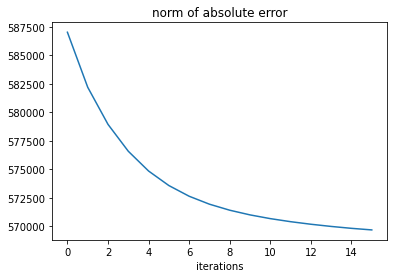

In [12]:
X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=100, tol=15000, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()

### the next iterations are NaN

## random: A_orig - uniform, x-normal

3697.2014578735066
22783.038159007967
33180.05853797711
9335.571395782299
4646.313634848423


/tmp/ipykernel_437396/467913587.py:5: RuntimeWarning: divide by zero encountered in true_divide
  a_inv_hat = np.divide(I_hat,a_hat)


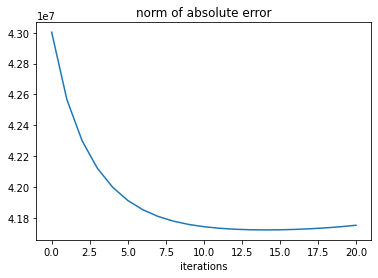

In [13]:
np.random.seed(0)
A_orig = np.random.rand(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.randn(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=100, tol=50000, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()

## random: A_orig - normal, x-uniform

3142.5990421057986
3787.7123708576923
4063.0169035120634
3639.7483620902594
3444.3769314620063


/tmp/ipykernel_437396/467913587.py:5: RuntimeWarning: divide by zero encountered in true_divide
  a_inv_hat = np.divide(I_hat,a_hat)


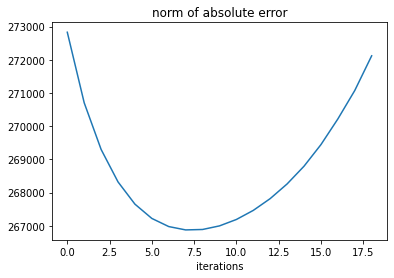

In [14]:
np.random.seed(0)
A_orig = np.random.randn(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.rand(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=100, tol=5000, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()

## random: A_orig - uniform, x-uniform

3030.4655940018406
10036.238334443144
13737.18426626633
3401.4952398839114
1721.213937624831


/tmp/ipykernel_437396/467913587.py:5: RuntimeWarning: divide by zero encountered in true_divide
  a_inv_hat = np.divide(I_hat,a_hat)


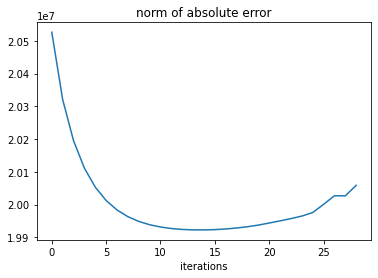

In [15]:
np.random.seed(0)
A_orig = np.random.rand(m, p, n)

A_tensor = m_prod(A_orig.transpose((1,0,2)), A_orig, funm_dct, invm_dct)+10*np.array(n*[np.identity(p)]).transpose((1,2,0))
X_true = np.random.rand(p, 1, n)
B = m_prod(A_tensor, X_true, funm_dct, invm_dct)

X, error = CG_M_tensor(A_tensor, B, funm_dct, invm_dct, iters=100, tol=20000, X_zero=None, X_true=X_true)
plt.plot(error)
plt.title('norm of absolute error')
plt.xlabel('iterations')
plt.show()